In [ ]:
# default_exp qfi

In [ ]:
#export 
import numpy as np
from scipy.optimize import curve_fit
from qiskit.circuit import Parameter
from qiskit.opflow import CircuitStateFn
from qiskit import QuantumCircuit, BasicAer

from fisherman.overlap.randomized import randomized_measurement_overlap

In [ ]:
#hide
from nbdev.showdoc import *
import matplotlib.pyplot as plt

# QFI

> Implementation of the method introduced in [this paper](https://arxiv.org/pdf/2104.00519.pdf).

In [ ]:
n_qubits = 1
backend = BasicAer.get_backend('statevector_simulator')

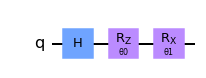

In [ ]:
theta0, theta1 = Parameter('θ0'), Parameter('θ1')
qc = QuantumCircuit(n_qubits)
qc.h(0)
qc.rz(theta0, 0)
qc.rx(theta1, 0)
qc.draw('mpl')

In [ ]:
state = CircuitStateFn(qc)
param_values = {theta0: np.pi/4, theta1: 0.1}
dtheta = np.round(np.arange(-0.1, 0.1, 0.01), 3)

In [ ]:
n_params, n_dth = len(state.parameters), len(dtheta)
params = state.primitive.parameters
qfi = np.zeros((n_params, n_params))
idx0 = np.argwhere(dtheta == 0).squeeze()

In [ ]:
def sub_qfi(x, qfi): return qfi*x**2

for i, param_i in enumerate(params):
    for j, param_j in enumerate(params[i:], i):
        d = 1 if i == j else 1/np.sqrt(2)
        param_dict = {p: [v]*n_dth for p, v in param_values.items()}
        param_dict[param_i] = [param_values[param_i] + dth*d for dth in dtheta]
        param_dict[param_j] = [param_values[param_j] + dth*d for dth in dtheta]

        overlap = randomized_measurement_overlap(state, param_dict=param_dict, n_rnd=256, local=False)

        if np.max(overlap) > 1: 
            overlap /= np.max(overlap)
        super_fidelity = overlap[idx0] + np.sqrt((1-overlap[idx0, idx0])*(1-overlap.diagonal()))
        bures_distance = 8*(1 - np.sqrt(super_fidelity))

        est_qfi, _ = curve_fit(sub_qfi, dtheta, bures_distance)
        qfi[i, j] = est_qfi

0 0 θ0 θ0
0 1 θ0 θ1
1 1 θ1 θ1


In [ ]:
i, j = 0, 1
param_i, param_j = theta0, theta1
d = 1 if i == j else 1/np.sqrt(2)
param_dict = {p: [v]*n_dth for p, v in param_values.items()}
param_dict[param_i] = [param_values[param_i] + dth*d for dth in dtheta]
param_dict[param_j] = [param_values[param_j] + dth*d for dth in dtheta]

overlap = randomized_measurement_overlap(state, param_dict=param_dict, n_rnd=256, local=False)

if np.max(overlap) > 1: 
    overlap /= np.max(overlap)
super_fidelity = overlap[idx0] + np.sqrt((1-overlap[idx0, idx0])*(1-overlap.diagonal()))
bures_distance = 8*(1 - np.sqrt(super_fidelity))

est_qfi, _ = curve_fit(sub_qfi, dtheta, bures_distance)
qfi[i, j] = est_qfi
est_qfi

array([1.32607772])

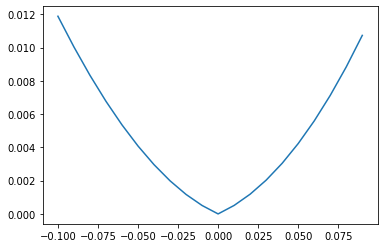

In [ ]:
plt.plot(dtheta, bures_distance)

In [ ]:
qfi

array([[1.13134914, 0.81363145],
       [0.        , 0.53422818]])

In [ ]:
param_values

{Parameter(θ0): 0.7853981633974483, Parameter(θ1): 0.1}

In [ ]:
param_dict

{Parameter(θ0): [0.5025554509228293,
  0.573266129041484,
  0.6439768071601388,
  0.7146874852787936,
  0.7853981633974483,
  0.856108841516103,
  0.9268195196347577,
  0.9975301977534126,
  1.0682408758720672],
 Parameter(θ1): [-0.182842712474619,
  -0.11213203435596422,
  -0.0414213562373095,
  0.029289321881345254,
  0.1,
  0.17071067811865476,
  0.2414213562373095,
  0.31213203435596426,
  0.382842712474619]}

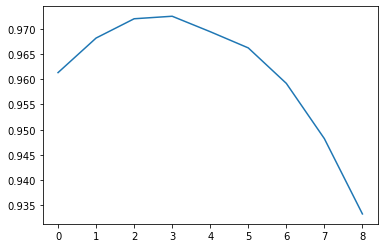

In [ ]:
plt.plot(overlap[4])